# Trainer
Script used for training both models more and more

In [1]:
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from tqdm.auto import tqdm
from sp_sims.learning.rl import RNNContinuousPolicy, Critic,ReplayBuffer
from torch import nn
import torch
import os.path
import numpy as np
import pickle
from sp_sims.detectors.pearsonneyman import *
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
from sp_sims.utils.utils import * 
import torch.optim as optim

from sp_sims.detectors.pearsonneyman import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import datetime
import argparse
from sklearn.metrics import roc_curve
from math import factorial
import sp_sims
from scipy.linalg import expm
from sp_sims.simulators.stochasticprocesses import *
from sp_sims.statistics.statistics import *
from sp_sims.estimators.algos import *
from IPython.display import clear_output
from sp_sims.sanitycheck.truebirthdeath import *
import sp_sims.utils.utils
import random
from itertools import product,islice
#from tqdm.notebook import tqdm

from tqdm import tqdm
from time import sleep
import time
#%matplotlib widget

Q0:
 [[-0.4  0.4]
 [ 1.2 -1.2]]
Q1:
 [[-10.   10. ]
 [ 12.2 -12.2]]
LamDiff = 9.6 MuDiff =11.0
Total Permutations:  16
Permutations [[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 1 1 1]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [0 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 1 1 1]]
Minimum Error is obtained at 11.039833162105994
This show that the summation of both errors is closer to monotonicity than having peaks.


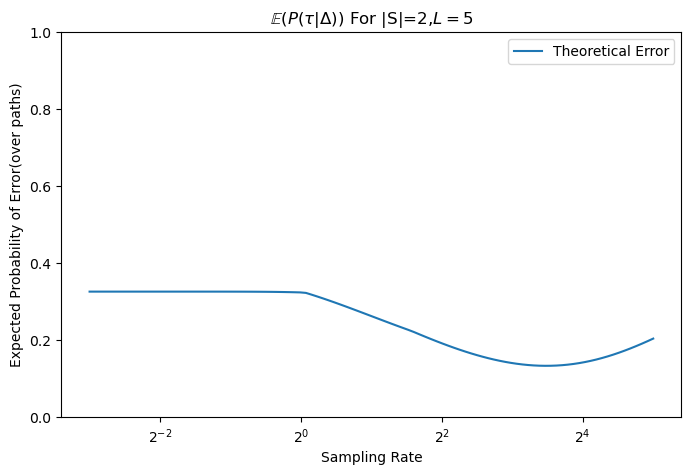

In [2]:
# Theoretical Stuff

class Args0:
  xres = 100
  #length = 10000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive
  init_state = 0
  num_samples = 5
  detection_guesses =1000
args0 = Args0()
# We want to calculate the average error probability for all paths
# We shouldn't be needing paths
from itertools import product

sp_sims.utils.utils.set_seed(0)
#np.random.seed(int(time.time()))
#num_steps = args.length
#num_states = args.state_limit+1
num_states = args0.state_limit+1

samp_rates = np.logspace(-3,5,args0.xres, base=2)

if (True):
    ## Two Variable Only
    #rates0 = {"lam": 4/10,"mu":12/10}
    ##rates1 = {"lam": 100/10,"mu":122/10}
    rates0 = {"lam": 4/10,  "mu":12/10}
    rates1 = {"lam": 100/10,"mu":122/10}
    #rates1 = {"lam": 168/10,"mu":248/10}
    #rates1 = {"lam": 2/15,"mu":49/10}
    Q0 = generate_true_gmatrix(rates0, args0.state_limit)
    Q1 = generate_true_gmatrix(rates1, args0.state_limit)
else:
    Q0 = random_bd_gmatrix(args0.state_limit)
    Q1 = random_bd_gmatrix(args0.state_limit)

rates = [rates0,rates1]
matrices = [Q0,Q1]
np.set_printoptions(precision=3)
print("Q0:\n",Q0)
print("Q1:\n",Q1)
print('LamDiff = {} MuDiff ={}'.format(Q0[0,0]-Q1[0,0],Q0[1,1]-Q1[1,1]))

# For Two States
#tgm0 = np.array([[-rates0['lam'],rates0['lam']],[rates0['mu'],-rates0['mu']]])
#tgm1 = np.array([[-rates1['lam'],rates1['lam']],[rates1['mu'],-rates1['mu']]])

hts, sts = ([],[])
last_times  = []
true_values = np.random.choice(2,args0.detection_guesses)
# Generate The Tapes
for i in range(args0.detection_guesses):
    #roe = RaceOfExponentials(args0.length,rates[true_values[i]],state_limit=args0.state_limit)
    roe = RaceOfExponentials(args0.num_samples*(1/samp_rates[0]), rates[true_values[i]],max_state=1)# TODO Remove that hardcoded 1
    #roe = GeneralEmbeddedMarkC(args0.length,matrices[true_values[i]])
    holdTimes_tape, state_tape = roe.generate_history(args0.init_state)
    hts.append(holdTimes_tape)
    sts.append(state_tape)
    last_times.append(np.cumsum(holdTimes_tape)[-1])

# Preparation of True Probabilities
true_p0s = []
true_p1s = []
fixed_guesses = np.ones((len(samp_rates), args0.detection_guesses))
# Crete all the *known* probability functions.
for srIdx, cur_samp_rate in enumerate(samp_rates):
    true_p0s.append(expm(Q0*(1/cur_samp_rate)))
    true_p1s.append(expm(Q1*(1/cur_samp_rate)))


# Generate
# TODO decrease memory consumption by only using iterators
num_steps = args0.num_samples
states = np.arange(num_states)
probs = []
tot_calcs = 0
if(num_steps < 6 or args0.state_limit >= 7): # Will crash memory
    paths = np.array(list(product(states, repeat=num_steps-1)))
    paths = np.concatenate([np.repeat([[0]],repeats=paths.shape[0], axis=0), paths], axis=1)
    # Sum them up and that should be your probability 
    tot_calcs = paths.shape[0]
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        #probs.append(np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))
        probs.append((1/2)*np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))
else:
    # For Each Sampling rate
    for srIdx, cur_samp_rate in enumerate(samp_rates):
        #probs.append(np.sum(np.apply_along_axis(prob_of_path, 1, paths, true_p0s[srIdx],true_p1s[srIdx])))
        paths = product(states, repeat=num_steps-1)
        prob = 0
        for batch in batched(paths,2**8):# Keep it at batches of 2**8 
            batch = np.array(batch)
            batched_paths = np.concatenate([np.repeat([[0]],repeats=batch.shape[0], axis=0), batch], axis=1)
            prob+= np.sum(np.apply_along_axis(prob_of_path, 1, batched_paths, true_p0s[srIdx],true_p1s[srIdx]))
            tot_calcs += batch.shape[[0]]
        prob *= 1/2
        probs.append(prob)
print("Total Permutations: ",tot_calcs)
print("Permutations",paths)

fig = plt.figure(figsize=(8,5))
plt.tight_layout()

plt.plot(samp_rates, probs, label='Theoretical Error')
plt.title('$\mathbb{E}(P(\\tau | \Delta ))$'+f' For |S|={args0.state_limit+1},$L={args0.num_samples}$')
print('Minimum Error is obtained at {}'.format(samp_rates[np.argmin(probs)]))
plt.xscale('log', base=2)
plt.legend()
plt.xlabel('Sampling Rate')
plt.ylabel('Expected Probability of Error(over paths)')
plt.ylim(0,1)
print('This show that the summation of both errors is closer to monotonicity than having peaks.')
plt.show()

In [3]:
given_path = './Models/05-21-2023_07-41-29'

if torch.backends.mps.is_available():
    print("Activating Apple Metal")
    device = torch.device("mps")
else:
    device = torch.device("cpu")

class CriticLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CriticLoss, self).__init__()
        #self.mse_loss = nn.MSELoss()
        self.mse_loss = nn.L1Loss()
        self.alpha = alpha

    def forward(self, est, true):
        return self.mse_loss(est,true) #+ self.alpha*torch.pow(1/est,2).mean()# Regularize it to  keep it away from 0 
class PolicyLoss(nn.Module):
    def __init__(self):
        super(PolicyLoss, self).__init__()

    def forward(self, estimation):
        return torch.mean(estimation)
    

class Args:
  xres = 100
  length = 5000# Number of transitions in continuous chain 
  state_limit = 1#Inclusive # DO NOT CHANGE, Architecture can't take it yet
  init_state = 0
  num_samples =5
  batch_size = 128
  poptimizer_lr = 1e-3
  coptimizer_lr = 1e-3
  #clipping_limit = 16 # Sampling rate no Bigger than this. 
  num_epochs = 100000
  detection_guesses = 1000
  num_replay_samples = 1 # How many batches do we sample at a time to learn 
# Data Class
class MetaState:
  states: list
  holding_times: list
  def __init__(self,states, holding_times):
    self.states = states
    self.holding_times = holding_times

args = Args()

Activating Apple Metal


In [4]:
# TODO remove hard code 
policy = RNNContinuousPolicy(2*2,hidden_size=16).to(device)
critic = Critic(2*2, 1, 16).to(device)
poptimizer = optim.Adam(policy.parameters(), lr = args.poptimizer_lr)
coptimizer = optim.Adam(critic.parameters(), lr = args.coptimizer_lr)

# Load it If Beed Be
#path = './ReplayBuffer/GAUSS_buffer_smpbud{}_to32.pkl'.format(args.num_samples)
path = './ReplayBuffer/PRECISE_buffer_smpbud{}_to256.pkl'.format(args.num_samples)
print('Using File ', path)
existed = os.path.exists(path)
rbuffer = ReplayBuffer(sampbudget=args.num_samples)
if existed:
    print('Found Previous Buffer, Now Loading...')
    with open(path, 'rb') as buffer_file:
        rbuffer.memory = pickle.load(buffer_file)


#rbuffer.populate_replay_buffer(args.batch_size,samp_method='uniform')

# We have Enough Data to Start Sampling and Exploring With 
qvalue_loss = []
policyExpectedReward = []
val_srate = []
qlosses,plosses = [],[]
q_losscrit = CriticLoss(alpha=0.5)
p_losscrit = PolicyLoss()

path = 'Models/05-21-2023_07-41-29/'
# Load Dicts
#policy.state_dict = torch.load(path+'Policy.pt')
#critic.state_dict = torch.load(path+'Critic.pt')
print('Rbuffer memory: ', len(rbuffer.memory))


Using File  ./ReplayBuffer/PRECISE_buffer_smpbud5_to256.pkl
Found Previous Buffer, Now Loading...
Rbuffer memory:  25600


  0%|          | 0/100000 [00:00<?, ?it/s]/Users/rac716/miniforge3/envs/rs39/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740439190/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


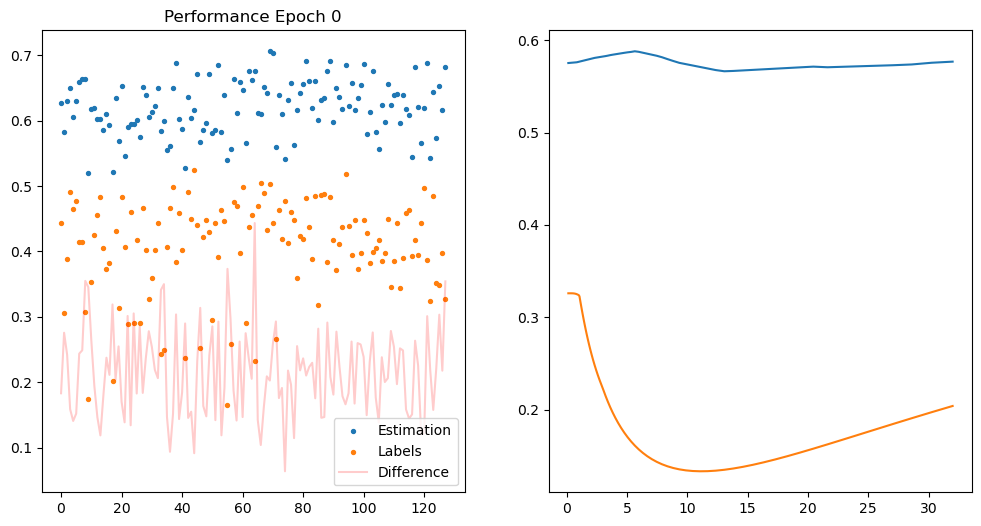

Parameter model.0.weight norm is 9.447
Parameter model.0.bias norm is 2.235
Parameter model.2.weight norm is 5.321
Parameter model.2.bias norm is 0.192
Parameter model.4.weight norm is 2.489
Parameter model.4.bias norm is 0.208
Parameter model.6.weight norm is 0.327
Parameter model.6.bias norm is 0.020
Parameter model.0.weight norm is 9.447_Q 1.8106317520141602 and loss_P 0.5908557176589966:   0%|          | 0/100000 [00:00<?, ?it/s]
Parameter model.0.bias norm is 2.235
Parameter model.2.weight norm is 5.321
Parameter model.2.bias norm is 0.192
Parameter model.4.weight norm is 2.489
Parameter model.4.bias norm is 0.208
Parameter model.6.weight norm is 0.327
Parameter model.6.bias norm is 0.020
Parameter model.0.weight norm is 9.449_Q 1.8106317520141602 and loss_P 0.5908557176589966:   0%|          | 1/100000 [00:00<16:33:52,  1.68it/s]
Parameter model.0.bias norm is 2.240
Parameter model.2.weight norm is 5.320
Parameter model.2.bias norm is 0.191
Parameter model.4.weight norm is 2.489


KeyboardInterrupt: 

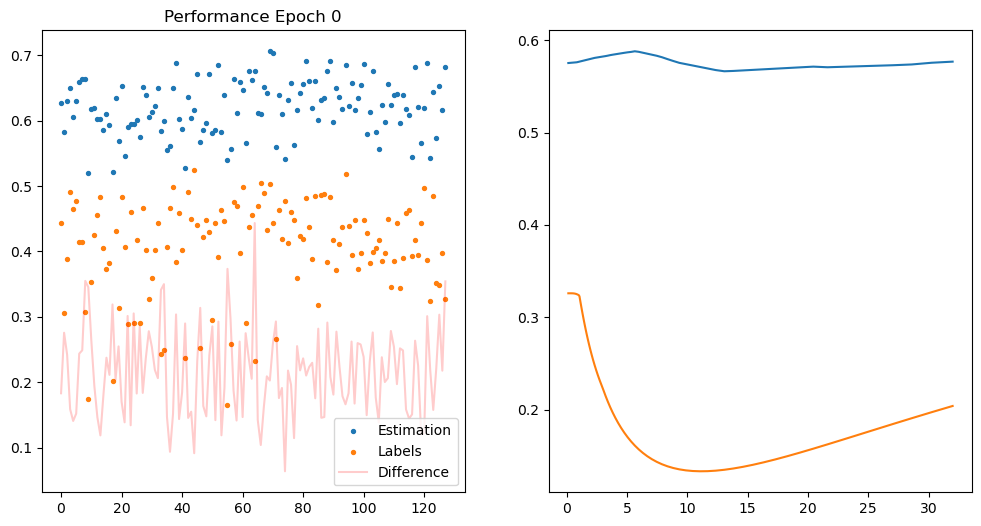

In [5]:
from IPython import display
policy.train()
critic.train()
epochs = tqdm(range(args.num_epochs),leave=False)
fig, axs = plt.subplots(1,2,figsize=(12,6))
for e in epochs:
    #clear_output(wait=True)
    poptimizer.zero_grad()
    coptimizer.zero_grad()
    ########################################
    # Collect Data
    ########################################
    # This loop will generate paths with the existing policy 
    # Sample Transitions used for learnign
    states, actions, rewards = rbuffer.sample(args.batch_size)
    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)

    # Get Rates
    y = rewards
    # Since We We are Doing Accuracy We have to create 
    ########################################
    # Update Networks
    ########################################
    # Calculate the Losses
    #loss_Q = (1/args2.batch_size)*torch.sum(torch.pow(critic(states, actions) - y,2))
    #loss_P = (1/args2.batch_size)*torch.sum(critic(states, policy(states)))
    loss_Q = q_losscrit(critic(states,actions), y)
    loss_P = p_losscrit(critic(states,policy(states)))

    # Learn 
    loss_Q.backward()
    loss_P.backward()
    poptimizer.step()
    coptimizer.step()

    qlosses.append(loss_Q.item())
    plosses.append(loss_P.item())

    # In this one particular case we have a single point that is global max so it would be
    # best to use optimized policy to do some exploration 
    qvalue_loss.append(loss_Q.item())
    policyExpectedReward.append(loss_P.item())

    # Validate with a known global min:
    validation_input = torch.tensor([[4/10,12/10,168/10,248/10]]).to(device)
    policy.eval()
    with torch.no_grad():
        val_srate.append(float(policy(validation_input).squeeze(-1).item()))
    policy.train()

    # Lets check performance 
    if e % 1000 == 0:
        axs[0].clear(), axs[1].clear()

        val = critic(states,actions).cpu().detach()
        axs[0].scatter(range(args.batch_size), val, label='Estimation',s=8)
        axs[0].scatter(range(args.batch_size), y.cpu(), label='Labels',s=8)
        axs[0].plot(range(args.batch_size), np.abs(val-y.cpu()), label='Difference', color='red',alpha=0.2)
        axs[0].set_title('Performance Epoch '+str(e))

        critic_a = torch.tensor(samp_rates).view(-1,1).to(torch.float32).to(device)
        critic_s = torch.tensor([4/10,12/10,100/10,122/10]).repeat(len(samp_rates),1).to(torch.float32).to(device)
        #critic_s = torch.tensor([4/10,12/10,168/10,248/10]).repeat(len(samp_rates),1).to(torch.float32).to(device)
        critic_y = critic(critic_s,critic_a).cpu().detach()

        axs[1].plot(samp_rates, critic_y, label='Estimated Error Rate')
        axs[1].plot(samp_rates, probs, label='True Error Rate')

        axs[0].legend()
        display.display(fig)
        #display.clear_output(wait=True)
        #plt.show()
    
    # Lets look at the weights acrooss the network 
    epoch_description = ""

    for name, param in critic.named_parameters():
        epoch_description += "Parameter {} norm is {:.3f}\n".format(name, torch.norm(param)**2)

    epoch_description += 'Val Samp Rate {}, Loss_Q {} and loss_P {}'.format(val_srate[-1], np.mean(qlosses), np.mean(plosses))

    epochs.set_description(epoch_description)

    ## Prep for Next Iteration
    # Keep On Adding More Stuff to buffer to learn from 
    #add_actions_to_buffer(rbuffer, states.cpu(), actions.cpu())

    # Don't over populate the buffer
    #if np.random.choice([0,1],1,p=[0.15,0.85]) == 0:
        #rbuffer.populate_replay_buffer(16, 'uniform')
        #pickle.dump(rbuffer, buffer_file, protocol=pickle.HIGHEST_PROTOCOL)
#buffer_file.close()
    


Val_srate :  [15.222990036010742, 15.840737342834473, 16.44288444519043, 17.038576126098633, 17.582317352294922, 18.158550262451172, 18.735057830810547, 19.627702713012695, 20.522842407226562, 21.31072425842285, 22.041807174682617, 22.693777084350586, 23.27031707763672, 23.758878707885742, 24.133995056152344, 24.401233673095703, 24.61808204650879, 24.786460876464844, 24.897418975830078, 24.95131492614746, 24.955411911010742, 24.916000366210938, 24.823198318481445, 24.693666458129883, 24.54182243347168, 24.359601974487305, 24.152198791503906, 23.926576614379883, 23.692668914794922, 23.461015701293945, 23.226791381835938, 22.99777603149414, 22.759248733520508, 22.51895523071289, 22.276798248291016, 22.054487228393555, 21.83551788330078, 21.63271713256836, 21.44746971130371, 21.268428802490234, 21.108264923095703, 20.95416831970215, 20.811548233032227, 20.69521713256836, 20.57701301574707, 20.471269607543945, 20.338272094726562, 20.19883155822754, 20.03993034362793, 19.867677688598633, 19

<Figure size 640x480 with 0 Axes>

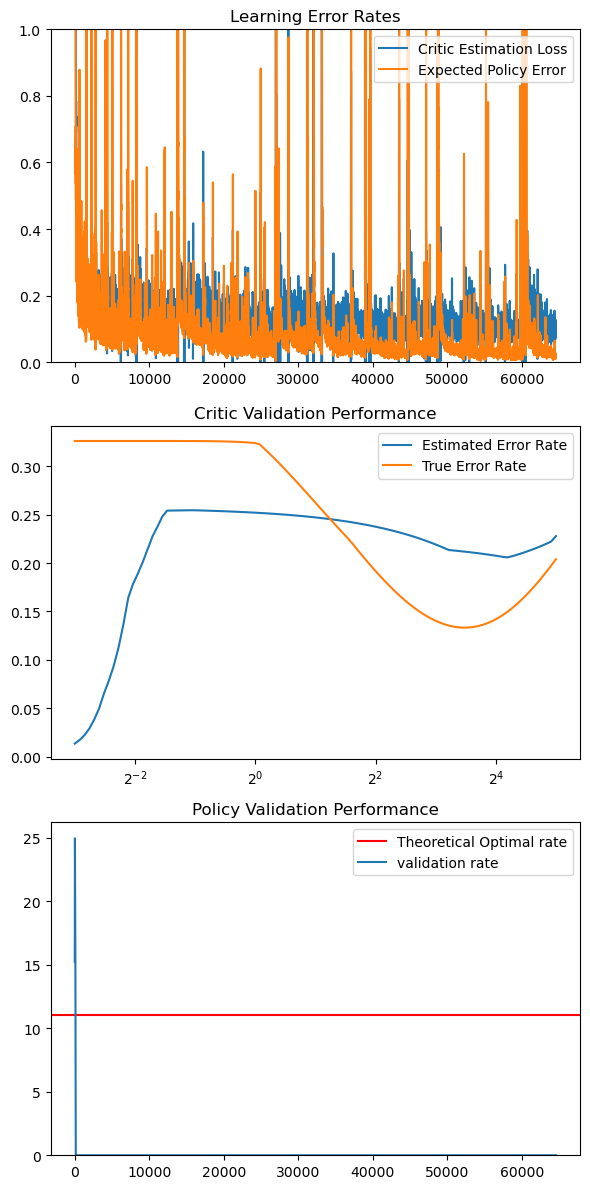

In [ ]:
from sp_sims.curve_filters.lowpass import savitzky_golay
importlib.reload(sp_sims.curve_filters.lowpass)
from datetime import datetime
now = datetime.now()
dtimestr = now.strftime("%m-%d-%y_%h:%m:%s")


critic_a = torch.tensor(samp_rates).view(-1,1).to(torch.float32).to(device)
#critic_s = torch.tensor([4/10,12/10,100/10,122/10]).repeat(len(samp_rates),1).to(torch.float32).to(device)
critic_s = torch.tensor([4/10,12/10,100/10,122/10]).repeat(len(samp_rates),1).to(torch.float32).to(device)
critic_y = critic(critic_s,critic_a).cpu().detach()/10

critic.eval()
plt.clf()

fig = plt.figure(figsize=(6,12))
gs = fig.add_gridspec(3,1)

axs0 = fig.add_subplot(gs[0,0])
axs0.set_title('Learning Error Rates')
axs0.plot(range(len(qlosses)),savitzky_golay(np.array(qlosses),51,3),label="Critic Estimation Loss")
axs0.plot(range(len(policyExpectedReward)),policyExpectedReward,label="Expected Policy Error")
axs0.set_ylim(0,1)
axs0.legend()


# printed estimated values 
axs1 = fig.add_subplot(gs[1,0])
axs1.set_title('Critic Validation Performance')
axs1.plot(samp_rates, critic_y, label='Estimated Error Rate')
axs1.plot(samp_rates, probs, label='True Error Rate')
axs1.set_xscale('log', base=2)
axs1.legend()

axs2 = fig.add_subplot(gs[2,0])
axs2.set_title('Policy Validation Performance')
axs2.axhline(y=11.03, label="Theoretical Optimal rate", color="red")
axs2.plot(range(len(val_srate)),val_srate,label="validation rate")
axs2.set_ylim(0,)
axs2.legend()
print("Val_srate : ",val_srate)

#fig.delaxes(fig.axes[-1])
plt.tight_layout()
plt.legend()

plt.savefig('images/models/training_{}.png'.format(dtimestr))

plt.show()


In [ ]:
# Save the Models
os.makedirs('Models/uniform{}'.format(dtimestr),exist_ok=True)
details = {
    'QLosses' : qvalue_loss,
    'Policy Expected Reward' : policyExpectedReward,
    'PLosses' : plosses,
    'Validation Rate' : val_srate,
    'Sampling Rates' : samp_rates,
    'critic_y' : critic_y,
    'Validation Probs': probs
}

torch.save(critic.state_dict ,'Models/uniform{}/critic.pt'.format(dtimestr))
torch.save(policy.state_dict ,'Models/uniform{}/policy.pt'.format(dtimestr))
torch.save(details,'Models/uniform{}/details.bin'.format(dtimestr))

with open('./ReplayBuffer/UNIFOM_packup_l{}.pkl'.format(args.num_samples),'wb') as f:
    pickle.dump(bu, f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()
    

In [ ]:
actions = [e[1] for e in rbuffer.memory]
states00 = [e[0][0] for e in rbuffer.memory]
states01 = [e[0][0] for e in rbuffer.memory]
states10 = [e[0][1] for e in rbuffer.memory]
states11 = [e[0][1] for e in rbuffer.memory]
plt.clf()
plt.hist(actions, bins=100,alpha=0.2)
plt.hist(states00, bins=100, alpha=0.2, label='lam0')
plt.hist(states01, bins=100,alpha=0.2,label='mu0')
plt.hist(states10, bins=100, alpha=0.2,label='lam1')
plt.hist(states11, bins=100,alpha=0.2,label='mu1')
plt.legend()
plt.show()